# Klasifikace 


Zatím jsme se zabývali jen regresními úlohami. Učení s učitelem (*supervised learning*) ale zahrnuje dvě hlavní skupiny úloh - regresní úlohy a klasifikační úlohy. 

Zatímco u regresních úloh je výstupem modelu spojitá hodnota (float), 
v klasifikačních úlohách představuje výstup modelu indikátor třídy (label).

Držme se našeho rybího trhu a ukažme si to na příkladu. Úloha predikovat váhu ryby byla regresní úloha, 
predikovali jsme spojitou hodnotu. 
Pokud budeme chtít predikovat druh ryby (okoun - *perch*, plotice - *roach*, štika - *pike*, ...), jedná se o predikci kategorické hodnoty, tedy o klasifikaci.

Klasifikační úlohy mají trochu jiné vlastnosti a logiku než úlohy regresní, proto  existují modely přímo určené na takové úlohy. Říká se jim klasifikátory. 

Zkusíme se ale nejdřív podívat na úlohu klasifikace z pohledu, který už známe, tedy z pohledu krajiny.

In [1]:
# načeteme si data 
import pandas as pd 
import numpy as np 
np.random.seed(2020)  # nastavení náhodného klasifikátoru

def read_fish_data(filename):
    return (
        pd.read_csv(filename, index_col=0)
        .rename(columns={
            "Species": "druh",
            "Weight": "vaha",
            "Length1": "delka1",
            "Length2": "delka2",
            "Length3": "delka3",
            "Height": "vyska",
            "Width": "sirka"})
        .replace({
            "Bream": "Cejn",
            "Parkki": "Parma",
            "Perch": "Okoun",
            "Pike": "Štika",
            "Roach": "Plotice",
            "Smelt": "Šprota",
            "Whitefish": "Síh"})
)

data = read_fish_data("static/fish_data.csv")
data.sample(10)

,druh,vaha,delka1,delka2,delka3,vyska,sirka,ID
18,Cejn,610.0,30.9,33.5,38.6,15.6330,5.1338,18
38,Plotice,87.0,18.2,19.8,22.2,5.6166,3.1746,38
119,Okoun,850.0,36.9,40.0,42.3,11.9286,7.1064,119
55,Síh,270.0,23.6,26.0,28.7,8.3804,4.2476,55
149,Šprota,9.8,10.7,11.2,12.4,2.0832,1.2772,149
130,Štika,300.0,32.7,35.0,38.8,5.9364,4.3844,130
33,Cejn,975.0,37.4,41.0,45.9,18.6354,6.7473,33
61,Parma,55.0,13.5,14.7,16.5,6.8475,2.3265,61
64,Parma,120.0,17.5,19.0,21.3,8.3922,2.9181,64
58,Síh,540.0,28.5,31.0,34.0,10.7440,6.5620,58


In [2]:
data.groupby("druh")["druh"].count().sort_values(ascending=False)

druh
Okoun      42
Cejn       29
Štika      15
Šprota     13
Plotice    12
Parma       8
Síh         4
Name: druh, dtype: int64

### Úkol 1: 
   
Nejčastějším druhem ryby je *Okoun*. Naším cílem je vytvořit klasifikátor, který pro zadané míry (váha, různé délky a šířky) vrátí informaci, zda se jedná o okouna nebo jiný druh. (Máme tedy pro jednoduchost jen dvě třídy, **Okoun** a **ostatní**.)

+ Uměla bys tuto úlohu napasovat na krajinu? Co by mohly být souřadnice a co nadmořská výška? 

+ Pokud ses úspěšně poprala s předchozím dotazem, můžeš na klasifikaci použít některý z regresních modelů (ano, asi to nebude ideální, když jde o klasifikaci, ale zkusme nejdříve to, co již umíme). Co ale bude hodnota odezvy a jak ji budeme interpretovat? 

 ## Klasifikační modely 

Přinášíme opět nějakou základní nabídku klasifikačních modelů:
   
+ [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

+ [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
    
+ [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
   - n_estimators, integer, optional (default=100)
   
+ [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
     - C, float, optional (default=1.0)
     - kernel,string, optional (default=’rbf’)
     
+ [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)  


### Úkol 2:
Vyberete si jeden model a zkuste natrénovat na ryby.


Nejprve připravíme data obdobně jako v minulé hodině. Jako sloupeček odezvy použijeme `True` pro okouny a `False` pro ostatní ryby. Sloupeček `Species` pak už nebudeme potřebovat, stejně tak můžeme vypustit sloupeček `ID`.

In [3]:
# připravme data
y = data["druh"] == "Okoun"
X = data.drop(columns=["ID", "druh"])

Dalším krokem je rozdělení na trénovací a validační data. Nezapomeňme na stratifikaci.

In [4]:
# rozdělme na trénovací a validační množinu
from sklearn.model_selection import train_test_split 
X_train_raw, X_test_raw, y_train, y_test =  train_test_split(X, y, stratify=y)

Podívejme se jaké je zastoupení okounů v trénovací a testovací množině (díky stratifikaci by mělo být procento okounů v obouch datasetech přibližně stejné). 

In [5]:
print(f"Trainset: {100 * y_train.sum()/len(y_train):.0f}%")
print(f"Testset:  {100 * y_test.sum()/len(y_test):.0f}%")

Trainset: 34%
Testset:  35%


Vstupní data už obsahují jen numerické hodnoty, ale raději je ještě přeškálujeme.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

Jako model zvolíme **rozhodovací strom**. Neboj se ale zkusit jiný klasifikátor dle své volby.

In [7]:
# vytvořme instanci třídy DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [8]:
# natrénujte
model.fit(X_train, y_train);

Máme natrénovaný model, jdeme se podívat, jak funguje na validačních datech.

In [9]:
# ohodnoťme validační množinu 
pred = model.predict(X_test) 

In [10]:
df_compare = (
    X_test_raw
    .assign(druh=y_test)
    .assign(predikce=pred)
)
df_compare["spravne"] = (df_compare["druh"] == df_compare["predikce"]).replace({True: "OK", False: ":("})
df_compare = df_compare.replace({True: "Okoun", False: "Ostatní"})

display(df_compare.sample(10))
print(f"Počet chyb ve validačních datech: {sum(y_test != pred)}")

,vaha,delka1,delka2,delka3,vyska,sirka,druh,predikce,spravne
122,820.0,37.1,40.0,42.5,11.1350,6.6300,Okoun,Ostatní,:(
156,12.2,12.1,13.0,13.8,2.2770,1.2558,Ostatní,Ostatní,OK
94,150.0,21.0,23.0,24.5,5.2185,3.6260,Okoun,Okoun,OK
121,1015.0,37.0,40.0,42.4,12.3808,7.4624,Okoun,Okoun,OK
62,60.0,14.3,15.5,17.4,6.5772,2.3142,Ostatní,Ostatní,OK
10,475.0,28.4,31.0,36.2,14.2628,5.1042,Ostatní,Ostatní,OK
18,610.0,30.9,33.5,38.6,15.6330,5.1338,Ostatní,Ostatní,OK
9,500.0,28.5,30.7,36.2,14.2266,4.9594,Ostatní,Ostatní,OK
151,10.0,11.3,11.8,13.1,2.2139,1.2838,Ostatní,Ostatní,OK
125,1100.0,40.1,43.0,45.5,12.5125,7.4165,Okoun,Okoun,OK


Počet chyb ve validačních datech: 2


### Úkol 3:

+ Asi je jasné, že regresní metriky se nám na klasifikační úlohy moc nehodí. Zamysli se, co bys použila jako metriku
 pro klasifikační úlohu. 

### Úkol 4: 

 - Jedna z možností je porovnávat procento úspěšně klasifikovaných vzorů. V našem případě, to bude: 

In [11]:
print(f"Úspěšnost: {100*sum(y_test == pred)/len(y_test):.2f} %")

Úspěšnost: 93.55 %


Úspěšnost není úplně špatná, poznat druh ryby podle rozměrů není jednoduchá úloha.

Představ si ale, že budeme mít v datovou množinu se 100 rybami, 95 z nich bude okounů. Bude ti klasifikátor, který bude mít toto procento úspěšnosti (stejné jako vyšlo nám), připadat dobrý nebo ne? Proč?   

### Úkol 5: 

Nejprve si projdeme klasifikační metriky. Pokud studuješ sama, nastuduj si [kapitolu o klasifikačních metrikách](../classification_metrics/) a pak se vrať k tomuto cvičení. 

Vyber si metriku pro naši úlohu a zkus najít, co nejlepší klasifikátor. Pak si načti testovací množinu a podívej se, jaké tvůj klasifikátor dává výsledky.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC

# zkus naučit různé modely a vyber nejlepší
models = {}

# KNeigbors 
for N in 1, 3, 5, 7:
    models[("nearest neighbors", N)] = KNeighborsClassifier(n_neighbors=N, weights="distance")
    
# tree
for d in range(3, 20):
    models[("tree", d)] = DecisionTreeClassifier(max_depth=d, class_weight='balanced')
    
# random forest
for N in range(1, 100, 2):
    models[("random forest", N)] = RandomForestClassifier(n_estimators=N, class_weight='balanced')
    
# SVC
for C in range(-2, 10):
    models[("SVC", 10**C)] = SVC(C=10**C, class_weight="balanced")

Vytvořili jsme si slušnou zásobu modelů, uložili jsme je do slovníku. Každý model máme pro různé hodnoty příslušného hyper-parametru. 
Všimni si i parametru `class_weight`, `"balanced"` zohlední různé počty vzorů v jednolivých třídách, t.j. máme-li 31 okounů a 61 ostatních, přiřadí třídě okounů větší důležitost (aby se vyrovala nerovnováha v počtu trénovacích vzorů). 

Obdobně jako v minulé hodině vytvoříme funci, která ohodnotí model a vrátí hodnoty vybrané metriky na trénovací a validační množině.
Hodnoty vrací ve slovníku (což nám pak umožní snadnější vytvoření *dataframu* s výsledky).

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def train_and_eval(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    return {
        "train": f1_score(y_train, y_pred_train), # metriku můžeš vyměnit za nějakou svojí
        "test": f1_score(y_test, y_pred_test)
    }

In [14]:
import tqdm 
results = []
for name, model in tqdm.tqdm(models.items()):
    res = train_and_eval(X_train, X_test, y_train, y_test, model)
    res["model"] = name[0]
    res["param"] = name[1]
    results.append(res)
    
df_results = pd.DataFrame(results).sort_values(["test", "train"], ascending=False)
df_results.head(10)

100%|█████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 15.27it/s]


,train,test,model,param
74,0.826667,0.956522,SVC,10.0
0,1.000000,0.952381,nearest neighbors,1.0
41,1.000000,0.952381,random forest,41.0
47,1.000000,0.952381,random forest,53.0
48,1.000000,0.952381,random forest,55.0
75,1.000000,0.952381,SVC,100.0
76,1.000000,0.952381,SVC,1000.0
77,1.000000,0.952381,SVC,10000.0
78,1.000000,0.952381,SVC,100000.0
79,1.000000,0.952381,SVC,1000000.0


Závislost úspěsnosti modelu (dle zvolené metriky) na hodnotě příslušného hyperparametru si zobrazíme v grafu.

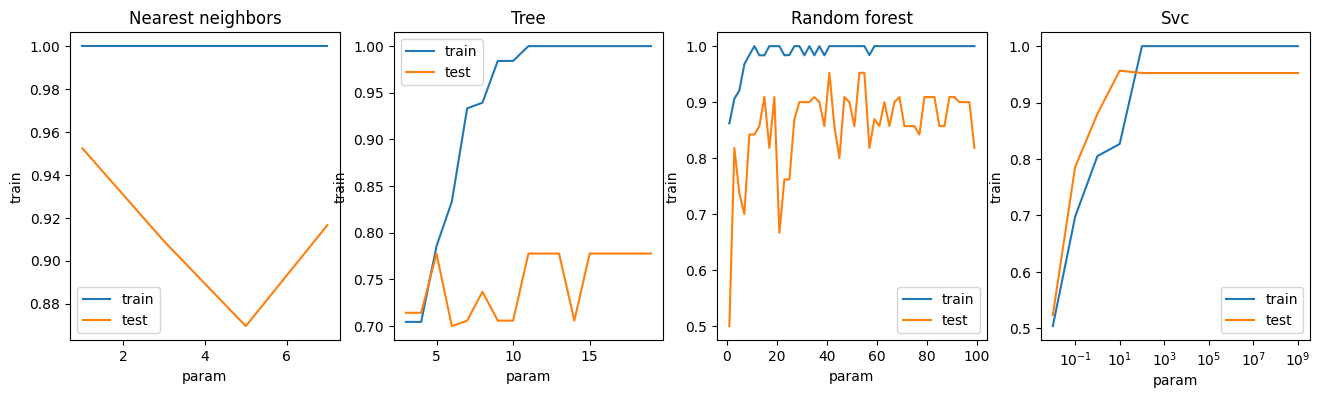

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def zobraz_model(model_name, ax, logx=False):
    sns.lineplot(x="param", y="train", data=df_results[df_results["model"]==model_name], 
                 markers=True, label="train", ax=ax)
    sns.lineplot(x="param", y="test", data=df_results[df_results["model"]==model_name], 
                 markers=True, label="test", ax=ax)
    ax.set_title(model_name.capitalize())
    if logx:
        ax.set(xscale="log")
    
fig, axs = plt.subplots(ncols=4, figsize=(16,4))
zobraz_model("nearest neighbors", axs[0])
zobraz_model("tree", axs[1])
zobraz_model("random forest", axs[2])
zobraz_model("SVC", axs[3], logx=True)

### Úkol 6:

Vyber si model, který se na validační množině jeví jako nejlepší. Vyzkoušej jej na testovací data.

In [16]:
# načtení data
test_data = read_fish_data("static/fish_data_test.csv")
y_real_test = test_data["druh"] == "Okoun"
y_real_test = y_real_test.astype(int)
X_real_test = test_data.drop(columns=["ID", "druh"])
X_real_test = scaler.transform(X_real_test)

In [17]:
# predikce
model = models[("SVC", 10**4)]
test_pred = model.predict(X_real_test)

In [18]:
df_compare = (
    pd.DataFrame()
    .assign(druh=y_real_test)
    .assign(predikce=test_pred)
)
df_compare["spravne"] = (df_compare["druh"] == df_compare["predikce"]).replace({True: "OK", False: ":("})
df_compare = df_compare.replace({True: "Okoun", False: "Ostatní"})

display(df_compare.sample(10))

print(f"Počet chyb: {sum(y_real_test != test_pred)}")
print(f"Úspěšnost: {100*sum(y_real_test == test_pred)/len(y_real_test):.2f} %")

,druh,predikce,spravne
99,1,Okoun,OK
157,0,Okoun,:(
60,0,Okoun,:(
144,0,Ostatní,OK
43,0,Ostatní,OK
22,0,Ostatní,OK
140,0,Ostatní,OK
105,1,Okoun,OK
107,1,Okoun,OK
36,0,Ostatní,OK


Počet chyb: 4
Úspěšnost: 88.89 %


In [19]:
from sklearn.metrics import precision_score

precision_score(y_real_test, test_pred)

0.8571428571428571

In [20]:
from sklearn.metrics import recall_score
recall_score(y_real_test, test_pred)

0.8571428571428571

# Bonus: Klasifikace do více tříd

Ukažme si pro úplnost, jak na klasifikaci do více tříd. 

In [21]:
data = read_fish_data("static/fish_data.csv")
data.sample(10)

,druh,vaha,delka1,delka2,delka3,vyska,sirka,ID
56,Síh,270.0,24.1,26.5,29.3,8.1454,4.2485,56
112,Okoun,685.0,34.0,36.5,39.0,10.8810,6.8640,112
93,Okoun,145.0,20.7,22.7,24.2,5.9532,3.6300,93
20,Cejn,575.0,31.3,34.0,39.5,15.1285,5.5695,20
156,Šprota,12.2,12.1,13.0,13.8,2.2770,1.2558,156
5,Cejn,450.0,26.8,29.7,34.7,13.6024,4.9274,5
158,Šprota,19.9,13.8,15.0,16.2,2.9322,1.8792,158
7,Cejn,390.0,27.6,30.0,35.0,12.6700,4.6900,7
149,Šprota,9.8,10.7,11.2,12.4,2.0832,1.2772,149
103,Okoun,260.0,25.4,27.5,28.9,7.1672,4.3350,103


Jako výstup vezmeme tentokrát sloupec druh, tak jak jej máme. Dělení na trénovací a validační data je stejné, jak ho známe.

In [22]:
y = data["druh"]
X = data.drop(columns=["druh", "ID"])

X_train_raw, X_test_raw, y_train, y_test =  train_test_split(X, y, stratify=y)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

Vezměme klasifikátor, u binární klasifikace se osvědčil `SVC`, tak u něj zůstaneme. Vhodné hyper-parametry nám tentokrát spadly z nebe, už jsme je pro vás vyladili.

In [24]:
klasifikator = SVC(class_weight="balanced", probability=True, C=10**5)
klasifikator.fit(X_train, y_train)

,C,100000
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


A máme naučeno, můžeme predikovat.

In [25]:
y_pred = klasifikator.predict(X_test)
y_pred

array(['Parma', 'Okoun', 'Štika', 'Šprota', 'Okoun', 'Cejn', 'Okoun',
       'Okoun', 'Cejn', 'Cejn', 'Cejn', 'Šprota', 'Okoun', 'Okoun',
       'Okoun', 'Štika', 'Parma', 'Štika', 'Okoun', 'Okoun', 'Okoun',
       'Okoun', 'Cejn', 'Cejn', 'Cejn', 'Okoun', 'Plotice', 'Okoun',
       'Štika', 'Šprota', 'Síh'], dtype=object)

Jak vidíte, klasikátor pro každý řádek validačního datasetu vrátil název třídy. 

In [26]:
from sklearn.metrics import accuracy_score
100 * accuracy_score(y_test, y_pred)

87.09677419354838

Máme klasifikováno téměř 84% validačních vzorků, to vypadá slibně. Podívejme se ale na *matici záměn* (confusion matrix), ta nám přinese více informace.

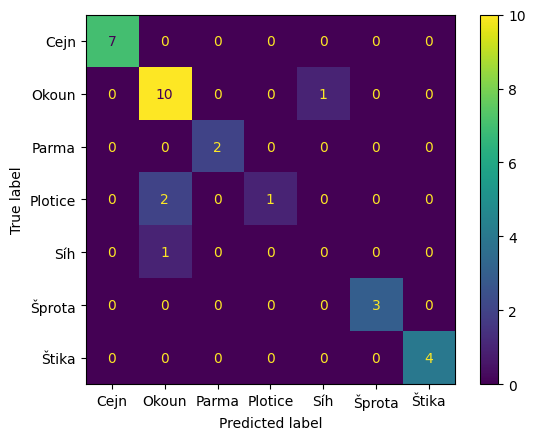

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, labels=klasifikator.classes_
);

Matice záměn nám prozradila, na kterých třídách klasifikátor chybuje a jak. Např. dvě parmy byly klasifikovány jako Cejni. Největší problém je s ploticemi, u kterých došlo k třem chybám. 